<font color=red > 准备工作: 在本机上安装anaconda,然后根据https://pytorch.org/get-started/locally/ 安装torch环境,文件较大,耗时较久.除本节外,后边的代码均在和鲸的平台,利用d2l-pytorch环境运行.
笔记以课程对应的notebook为基础,根据对相关书籍和辅修课程的学习补充笔记到notebook中.
</font> 

# 线性回归
主要内容包括：

1. 线性回归的基本要素
2. 线性回归模型从零开始的实现
3. 线性回归模型使用pytorch的简洁实现

## 线性回归的基本要素

### 模型
为了简单起见，这里我们假设价格只取决于房屋状况的两个因素，即面积（平方米）和房龄（年）。接下来我们希望探索价格与这两个因素的具体关系。线性回归假设输出与各个输入之间是线性关系:


$$
\mathrm{price} = w_{\mathrm{area}} \cdot \mathrm{area} + w_{\mathrm{age}} \cdot \mathrm{age} + b
$$



### 数据集
我们通常收集一系列的真实数据，例如多栋房屋的真实售出价格和它们对应的面积和房龄。我们希望在这个数据上面寻找模型参数来使模型的预测价格与真实价格的误差最小。在机器学习术语里，该数据集被称为训练数据集（training data set）或训练集（training set），一栋房屋被称为一个样本（sample），其真实售出价格叫作标签（label），用来预测标签的两个因素叫作特征（feature）。特征用来表征样本的特点。
### 损失函数
在模型训练中，我们需要衡量价格预测值与真实值之间的误差。通常我们会选取一个非负数作为误差，且数值越小表示误差越小。一个常用的选择是平方损失函数(squared loss,对预测误差大的有更大的惩罚,容忍很小的预测误差,可以有效地提升模型的泛化能力)。 它在评估索引为 $i$ 的样本误差的表达式为


$$
l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2,
$$

每次取一个小批量,就是下边的计算公式

$$
L(\mathbf{w}, b) =\frac{1}{n}\sum_{i=1}^n l^{(i)}(\mathbf{w}, b) =\frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.
$$


### 优化函数 - 随机梯度下降
当模型和损失函数形式较为简单时，上面的误差最小化问题的解可以直接用公式表达出来。这类解叫作解析解（analytical solution）。本节使用的线性回归和平方误差刚好属于这个范畴。然而，大多数深度学习模型并没有解析解，只能通过优化算法有限次迭代模型参数来尽可能降低损失函数的值。这类解叫作数值解（numerical solution）。

在求数值解的优化算法中，小批量随机梯度下降（mini-batch stochastic gradient descent,综合了批量梯度下降BGD和随机梯度下降SGD的优点）在深度学习中被广泛使用。它的算法很简单：先选取一组模型参数的初始值，如随机选取；接下来对参数进行多次迭代，使每次迭代都可能降低损失函数的值。在每次迭代中，先随机均匀采样一个由固定数目训练数据样本所组成的小批量（mini-batch）$\mathcal{B}$，然后求小批量中数据样本的平均损失有关模型参数的导数（梯度），最后用此结果与预先设定的一个正数的乘积作为模型参数在本次迭代的减小量。   

$$
(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{(\mathbf{w},b)} l^{(i)}(\mathbf{w},b)
$$
  
学习率: $\eta$代表在每次优化中，能够学习的步长的大小,   
批量大小: $\mathcal{B}$是小批量计算中的批量大小batch size   

学习率和批量大小是人为设定的,不是通过模型训练学出的,因此称之为超参数(hyperparameter).

总结一下，优化函数的有以下两个步骤：

- (i)初始化模型参数，一般来说使用随机初始化；
- (ii)我们在数据上迭代多次，通过在负梯度方向移动参数来更新每个参数。

## 矢量计算
在模型训练或预测时，我们常常会同时处理多个数据样本并用到矢量计算。在介绍线性回归的矢量计算表达式之前，让我们先考虑对两个向量相加的两种方法。


1. 向量相加的一种方法是，将这两个向量按元素逐一做标量加法。
2. 向量相加的另一种方法是，将这两个向量直接做矢量加法。

In [1]:
import torch
import time

# init variable a, b as 1000 dimension vector
n = 1000
a = torch.ones(n)
b = torch.ones(n)


In [2]:
# define a timer class to record time
class Timer(object):
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        # start the timer
        self.start_time = time.time()

    def stop(self):
        # stop the timer and record time into a list
        self.times.append(time.time() - self.start_time)
        return self.times[-1]

    def avg(self):
        # calculate the average and return
        return sum(self.times)/len(self.times)

    def sum(self):
        # return the sum of recorded time
        return sum(self.times)

现在我们可以来测试了。首先将两个向量使用for循环按元素逐一做标量加法。

In [3]:
timer = Timer()
c = torch.zeros(n)
for i in range(n):
    c[i] = a[i] + b[i]
'%.5f sec' % timer.stop() # 参数 '%.5f sec'表示保留五位小数,如果配置特别好可以增加有效位数使得显示的时间不为0

'0.02200 sec'

另外是使用torch来将两个向量直接做矢量加法：

In [4]:
timer.start()
d = a + b
'%.5f sec' % timer.stop()

'0.00100 sec'

结果很明显,后者比前者运算速度更快。因此，我们应该尽可能采用矢量计算，以提升计算效率。

## 线性回归模型从零开始的实现



In [5]:
# import packages and modules
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

print(torch.__version__) #本机的版本是1.4.0,和鲸平台上的版本是1.3.0

1.4.0


### 生成数据集
使用线性模型来生成数据集，生成一个1000个样本的数据集，下面是用来生成数据的线性关系：

$$
\mathrm{price} = w_{\mathrm{area}} \cdot \mathrm{area} + w_{\mathrm{age}} \cdot \mathrm{age} + b
$$



In [6]:
# set input feature number 
num_inputs = 2
# set example number
num_examples = 1000

# set true weight and bias in order to generate corresponded label
true_w = [2, -3.4]
true_b = 4.2

features = torch.randn(num_examples, num_inputs,
                      dtype=torch.float32)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()),  
# 为了模拟真实数据,增加了符合正态分布的小的偏差
                       dtype=torch.float32)

### 使用图像来展示生成的数据

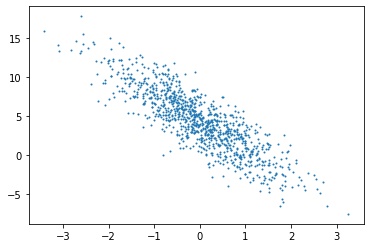

In [7]:
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);

### 读取数据集

In [8]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # random read 10 samples 使用shuffle函数打乱数据顺序
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # the last time may be not enough for a whole batch
        yield  features.index_select(0, j), labels.index_select(0, j)

In [9]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.1290, -1.1000],
        [ 0.4190,  0.7133],
        [ 0.2663,  0.7902],
        [-1.4476,  0.7135],
        [ 1.1073, -0.6617],
        [ 0.5837, -0.6599],
        [-0.8714,  0.5870],
        [ 0.7650,  0.1747],
        [-0.8336, -0.1698],
        [-1.4624,  0.8141]]) 
 tensor([ 8.2029,  2.5958,  2.0475, -1.1196,  8.6705,  7.5971,  0.4718,  5.1263,
         3.1131, -1.4961])


### 初始化模型参数

In [10]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0.], requires_grad=True)

### 定义模型
定义用来训练参数的训练模型：

$$
\mathrm{price} = w_{\mathrm{area}} \cdot \mathrm{area} + w_{\mathrm{age}} \cdot \mathrm{age} + b
$$



In [11]:
def linreg(X, w, b):
    return torch.mm(X, w) + b #mm表示矩阵相乘

In [12]:
torch.mm??
#查看torch.mm的源码.在和鲸上不能成功运行.

Docstring:
mm(input, mat2, out=None) -> Tensor

Performs a matrix multiplication of the matrices :attr:`input` and :attr:`mat2`.

If :attr:`input` is a :math:`(n \times m)` tensor, :attr:`mat2` is a
:math:`(m \times p)` tensor, :attr:`out` will be a :math:`(n \times p)` tensor.

.. note:: This function does not :ref:`broadcast <broadcasting-semantics>`.
          For broadcasting matrix products, see :func:`torch.matmul`.

Args:
    input (Tensor): the first matrix to be multiplied
    mat2 (Tensor): the second matrix to be multiplied
    out (Tensor, optional): the output tensor.

Example::

    >>> mat1 = torch.randn(2, 3)
    >>> mat2 = torch.randn(3, 3)
    >>> torch.mm(mat1, mat2)
    tensor([[ 0.4851,  0.5037, -0.3633],
            [-0.0760, -3.6705,  2.4784]])
Type:      builtin_function_or_method


### 定义损失函数
我们使用的是均方误差损失函数：
$$
l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2,
$$


In [13]:
def squared_loss(y_hat, y): 
    return (y_hat - y.view(y_hat.size())) ** 2 / 2 
    #使用y.view方法将y的形状设置为和y_hat一致,以便于能够相减

### 定义优化函数
在这里优化函数使用的是小批量随机梯度下降：

$$
(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{(\mathbf{w},b)} l^{(i)}(\mathbf{w},b)
$$
  

In [14]:
def sgd(params, lr, batch_size): 
    for param in params:
        param.data -= lr * param.grad / batch_size 
        # ues .data to operate param without gradient track 
        #对参数优化的动作不被附加

### 训练
当数据集、模型、损失函数和优化函数定义完了之后就可来准备进行模型的训练了。


In [15]:
# super parameters init
lr = 0.03 #设置学习率
num_epochs = 5 #设置训练周期

net = linreg #使用线性网络(模型)
loss = squared_loss  #使用均方误差函数

# training
for epoch in range(num_epochs):  # training repeats num_epochs times
    # in each epoch, all the samples in dataset will be used once
    #第一层循环,按训练周期
    # X is the feature and y is the label of a batch sample
    for X, y in data_iter(batch_size, features, labels):
        #第二层循环,按数据的批量
        l = loss(net(X, w, b), y).sum()  
        # calculate the gradient of batch sample loss 
        l.backward()  
        # using small batch random gradient descent to iter model parameters
        sgd([w, b], lr, batch_size)  
        # reset parameter gradient
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.031103
epoch 2, loss 0.000112
epoch 3, loss 0.000050
epoch 4, loss 0.000050
epoch 5, loss 0.000050


In [16]:
w, true_w, b, true_b

(tensor([[ 1.9996],
         [-3.4011]], requires_grad=True),
 [2, -3.4],
 tensor([4.2000], requires_grad=True),
 4.2)

## 线性回归模型使用pytorch的简洁实现


In [17]:
import torch
from torch import nn
import numpy as np
torch.manual_seed(1)

print(torch.__version__) #版本号,使用本机配置的环境,与视频中不一样,视频中是1.3.0
torch.set_default_tensor_type('torch.FloatTensor')

1.4.0


### 生成数据集
在这里生成数据集跟从零开始的实现中是完全一样的。

In [18]:
num_inputs = 2
num_examples = 1000

true_w = [2, -3.4]
true_b = 4.2

features = torch.tensor(np.random.normal(0, 1, (num_examples, num_inputs)), dtype=torch.float)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

In [19]:
print(labels)

tensor([-2.7415e+00,  6.4484e+00,  7.5015e+00,  1.0622e+01,  5.6058e+00,
         7.0016e+00,  2.5469e-01,  3.0772e+00,  2.6768e+00,  7.4729e+00,
         2.5394e+00,  5.6834e+00,  3.0350e+00,  2.9557e-01,  6.8819e+00,
         9.8630e+00,  5.3412e+00, -6.3359e-01,  5.1206e+00,  4.9572e+00,
         3.9963e+00,  9.7220e+00, -5.0951e-01,  4.2447e+00, -4.2502e+00,
         4.7546e+00,  5.2780e+00, -8.8956e-01,  2.0689e+00,  7.6431e-01,
         4.0784e+00,  3.0248e+00,  8.6177e-01,  3.8281e+00,  8.3350e+00,
         4.4403e+00,  3.6917e+00,  3.5064e+00,  2.7649e+00,  1.0217e+01,
         8.4279e+00,  2.5902e+00,  6.3396e+00,  1.8796e+00,  4.8207e+00,
        -1.0181e+00,  5.3022e+00,  8.7944e+00,  7.7782e+00,  8.5616e-01,
         3.6401e+00, -6.4594e+00,  5.5580e+00,  7.5307e+00, -3.3760e+00,
         8.6850e+00,  1.1298e+01,  1.2539e+00,  6.7631e+00,  4.9536e+00,
         8.4108e+00,  2.4283e+00,  4.9057e+00,  5.1341e+00,  7.3259e+00,
        -2.3421e+00,  1.9409e+00,  3.7598e-01,  9.6

### 读取数据集

In [20]:
import torch.utils.data as Data

batch_size = 10 

# combine featues and labels of dataset
dataset = Data.TensorDataset(features, labels)

# put dataset into DataLoader
data_iter = Data.DataLoader(
    dataset=dataset,            # torch TensorDataset format
    batch_size=batch_size,      # mini batch size
    shuffle=True,               # whether shuffle the data or not
    num_workers=2,              # read data in multithreading
)

In [21]:
for X, y in data_iter:
    print(X, '\n', y)
    break

tensor([[-0.4394, -0.2733],
        [ 0.5088,  0.6244],
        [-3.1206,  2.5311],
        [-1.1006, -0.1709],
        [-1.3650,  0.6217],
        [-0.7348, -1.3356],
        [-0.8313, -0.2667],
        [-0.6025,  0.0201],
        [-0.2095,  0.1451],
        [ 1.4455, -0.1782]]) 
 tensor([  4.2529,   3.1025, -10.6429,   2.5887,  -0.6377,   7.2721,   3.4450,
          2.9341,   3.2818,   7.7090])


### 定义模型

In [22]:
class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super(LinearNet, self).__init__()      # call father function to init 
        self.linear = nn.Linear(n_feature, 1)  # function prototype: `torch.nn.Linear(in_features, out_features, bias=True)`

    def forward(self, x):
        y = self.linear(x)
        return y
    
net = LinearNet(num_inputs)
print(net)

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


In [23]:
# ways to init a multilayer network
# method one
net = nn.Sequential(
    nn.Linear(num_inputs, 1)
    # other layers can be added here
    )

# method two
net = nn.Sequential()
net.add_module('linear', nn.Linear(num_inputs, 1))
# net.add_module ......

# method three
from collections import OrderedDict
net = nn.Sequential(OrderedDict([
          ('linear', nn.Linear(num_inputs, 1))
          # ......
        ]))

print(net)
print(net[0])

Sequential(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Linear(in_features=2, out_features=1, bias=True)


### 初始化模型参数

In [24]:
from torch.nn import init

init.normal_(net[0].weight, mean=0.0, std=0.01) #innit模块中的normal_初始化方法
init.constant_(net[0].bias, val=0.0)  
# or you can use `net[0].bias.data.fill_(0)` to modify it directly

Parameter containing:
tensor([0.], requires_grad=True)

In [25]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[-0.0142, -0.0161]], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)


### 定义损失函数

In [26]:
loss = nn.MSELoss()    
# nn built-in squared loss function 
#直接调用nn模块中的均方误差损失函数
# function prototype: `torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean')`

### 定义优化函数

In [27]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.03)   
# built-in random gradient descent function 
#调用随机梯度下降函数作为优化函数
print(optimizer)  
# function prototype: `torch.optim.SGD(params, lr=, momentum=0, dampening=0, weight_decay=0, nesterov=False)`

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


### 训练

In [28]:
num_epochs = 18 #设置为较大的周期,发现随着训练周期变大,损失会震荡
for epoch in range(1, num_epochs + 1): #第一层循环,也是训练周期的循环
    for X, y in data_iter:             #第二层循环是对数据循环
        output = net(X)
        l = loss(output, y.view(-1, 1))
        optimizer.zero_grad() # reset gradient, equal to net.zero_grad() 
        #梯度清零,防止梯度累加
        l.backward()
        optimizer.step()
    print('epoch %d, loss: %f' % (epoch, l.item()))

epoch 1, loss: 0.000226
epoch 2, loss: 0.000171
epoch 3, loss: 0.000046
epoch 4, loss: 0.000059
epoch 5, loss: 0.000123
epoch 6, loss: 0.000114
epoch 7, loss: 0.000039
epoch 8, loss: 0.000044
epoch 9, loss: 0.000068
epoch 10, loss: 0.000172
epoch 11, loss: 0.000100
epoch 12, loss: 0.000111
epoch 13, loss: 0.000123
epoch 14, loss: 0.000165
epoch 15, loss: 0.000085
epoch 16, loss: 0.000139
epoch 17, loss: 0.000081
epoch 18, loss: 0.000074


In [29]:
# result comparision #比较真实的结果和偏差以及训练出来的结果和偏差
dense = net[0]
print(true_w, dense.weight.data)
print(true_b, dense.bias.data)

[2, -3.4] tensor([[ 2.0003, -3.3994]])
4.2 tensor([4.1999])


## 两种实现方式的比较
1. 从零开始的实现（推荐用来学习）

   能够更好的理解模型和神经网络底层的工作原理
   

2. 使用pytorch的简洁实现

   能够更加快速地完成模型的设计与实现
   